In [1]:
#✅ שלב 1 – חיבור Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ✅ train_plants.ipynb – אימון MobileNetV2 עם חלוקה 80/10/10

# 🔢 שלב 1 – טעינת ספריות ועיבוד נתיב המקור
import os, shutil, random, sys
from tqdm import tqdm

original_dir = "/content/PlantVillage/color"
split_dir = "/content/PlantVillage_split"
train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)


In [3]:

# 🔢 שלב 2 – העתקת תיקיית התמונות מה-Drive
!cp -r "/content/drive/MyDrive/plantvillagedataset/plantvillagedataset/color/." "/content/PlantVillage/color"


In [4]:

# 🔍 שלב 2.5 – הדפסת שמות וכמות התיקיות וכמות התמונות לפני ניקוי
folder_list = [f for f in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, f))]
print(f"\n📁 מספר תיקיות לפני ניקוי: {len(folder_list)}\n")
print("📂 שמות התיקיות וכמות התמונות:")

with open("/content/class_folders.txt", "w") as f:
    for name in sorted(folder_list):
        path = os.path.join(original_dir, name)
        num_images = len([img for img in os.listdir(path) if os.path.isfile(os.path.join(path, img))])
        line = f"- {name}: {num_images} images"
        print(line)
        f.write(line + "\n")

# ✅ בדיקה – האם יש בדיוק 38 תיקיות?
if len(folder_list) != 38:
    print(f"❌ שגיאה: קיימות {len(folder_list)} תיקיות במקום 38.")
    sys.exit(1)  # עצירה מיידית של הקוד



📁 מספר תיקיות לפני ניקוי: 38

📂 שמות התיקיות וכמות התמונות:
- Apple___Apple_scab: 630 images
- Apple___Black_rot: 615 images
- Apple___Cedar_apple_rust: 275 images
- Apple___healthy: 1644 images
- Blueberry___healthy: 1501 images
- Cherry_(including_sour)___Powdery_mildew: 1052 images
- Cherry_(including_sour)___healthy: 854 images
- Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
- Corn_(maize)___Common_rust_: 1184 images
- Corn_(maize)___Northern_Leaf_Blight: 985 images
- Corn_(maize)___healthy: 1162 images
- Grape___Black_rot: 1180 images
- Grape___Esca_(Black_Measles): 1383 images
- Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
- Grape___healthy: 423 images
- Orange___Haunglongbing_(Citrus_greening): 5486 images
- Peach___Bacterial_spot: 2297 images
- Peach___healthy: 360 images
- Pepper,_bell___Bacterial_spot: 997 images
- Pepper,_bell___healthy: 1478 images
- Potato___Early_blight: 1000 images
- Potato___Late_blight: 988 images
- Potato___healthy: 152 im

In [5]:

# 🔢 שלב 3 – ניקוי תיקיות מיותרות וכפולות
cleaned_classes = set()
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    # הסרת תיקיות עם פחות מ־10 קבצים או תיקיות כפולות (כמו 'class (1)')
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if len(image_files) < 10 or class_name in cleaned_classes:
        shutil.rmtree(class_path)
    else:
        cleaned_classes.add(class_name)


In [6]:
# 🔢 שלב 3 – חלוקת התמונות ל־Train / Val / Test
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = os.listdir(class_path)
    random.shuffle(images)
    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    splits = {
        train_dir: images[:train_count],
        val_dir: images[train_count:train_count + val_count],
        test_dir: images[train_count + val_count:]
    }

    for target, files in splits.items():
        class_target = os.path.join(target, class_name)
        os.makedirs(class_target, exist_ok=True)
        for img in tqdm(files, desc=f"{target}/{class_name}", leave=False):
            shutil.copy2(os.path.join(class_path, img), os.path.join(class_target, img))

print("\u2705 Done splitting into train / val / test")


✅ Done splitting into train / val / test


In [7]:
# 🔢 שלב 4 – הגדרת ImageDataGenerators
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


Found 43327 images belonging to 38 classes.
Found 5402 images belonging to 38 classes.
Found 5446 images belonging to 38 classes.


In [8]:
# 🔢 שלב 5 – בניית MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model = MobileNetV2(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# 🔢 שלב 6 – הגדרת Callback ואימון המודל כולל שמירה אוטומטית (ModelCheckpoint)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="/content/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    checkpoint
]

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7079 - loss: 1.0921
Epoch 1: val_loss improved from inf to 0.28311, saving model to /content/best_model.keras
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 497s 356ms/step - accuracy: 0.7080 - loss: 1.0918 - val_accuracy: 0.9148 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 2/20
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9006 - loss: 0.3136
Epoch 2: val_loss improved from 0.28311 to 0.24738, saving model to /content/best_model.keras
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 457s 338ms/step - accuracy: 0.9006 - loss: 0.3136 - val_accuracy: 0.9204 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 3/20
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9118 - loss: 0.2668
Epoch 3: val_loss improved from 0.24738 to 0.21406, saving model to /content/best_model.keras
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 457s 338ms/step - accuracy: 0.9118 - loss: 0.2668 - val_accuracy: 0.9274 - val_loss: 0.2141 - learning_rate: 0.0010
Epoch 4/20


In [10]:
# 🔢 שלב 7 – הערכת המודל על סט ה־Test
test_loss, test_acc = model.evaluate(test_gen)
print(f"\U0001F3AF Test Accuracy: {test_acc:.2%}, Loss: {test_loss:.4f}")


171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9636 - loss: 0.1135
🎯 Test Accuracy: 94.86%, Loss: 0.1627


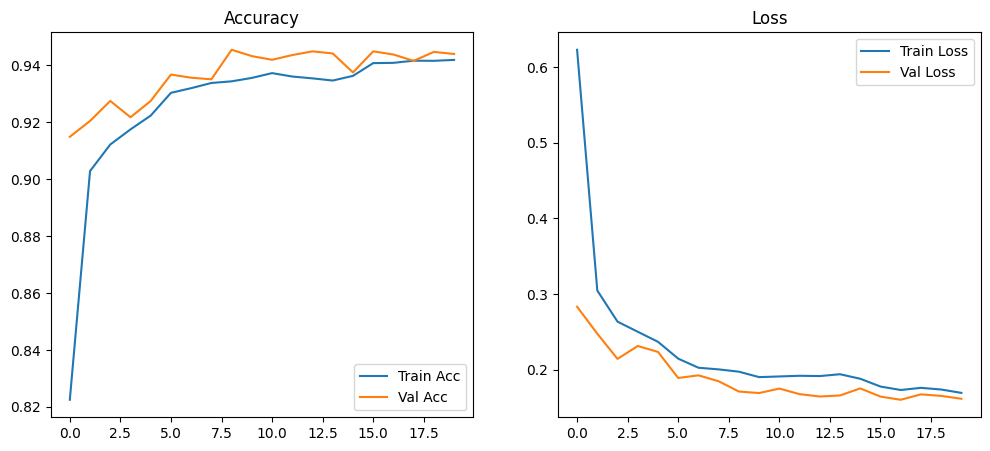

171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step


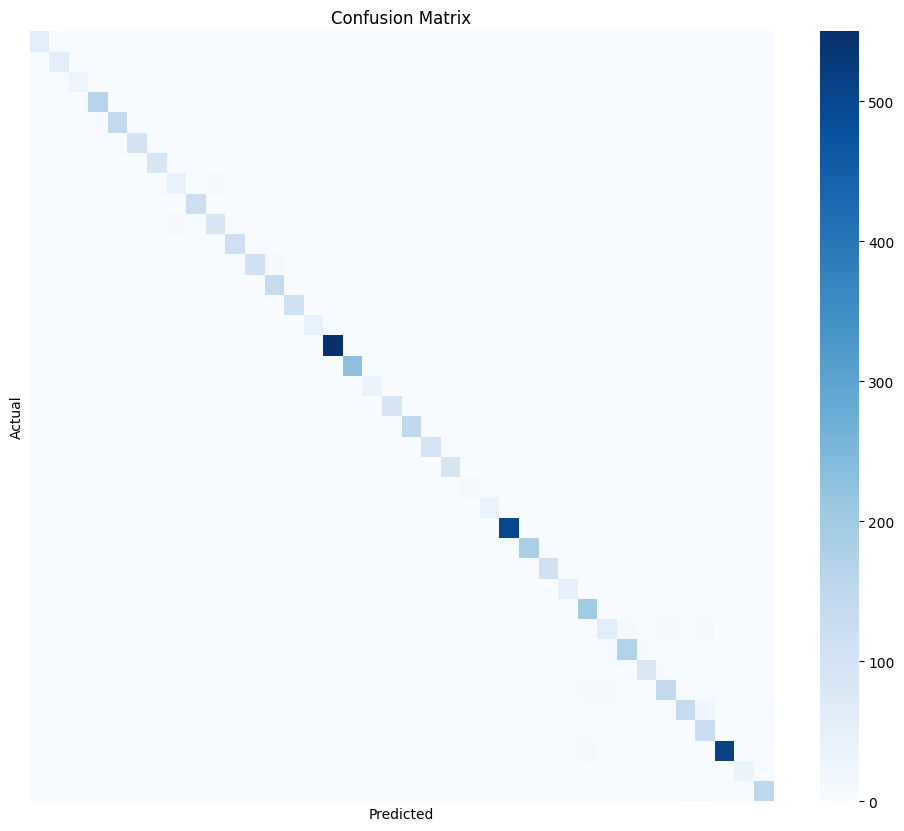


📋 Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.97      0.95        63
                                 Apple___Black_rot       1.00      0.95      0.98        62
                          Apple___Cedar_apple_rust       1.00      0.89      0.94        28
                                   Apple___healthy       0.96      0.99      0.98       165
                               Blueberry___healthy       1.00      0.93      0.97       151
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.99       106
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.75      0.80        52
                       Corn_(maize)___Common_rust_       0.97      1.00      0.98       119
               Corn_(maize)___Northern_Leaf_Blight  

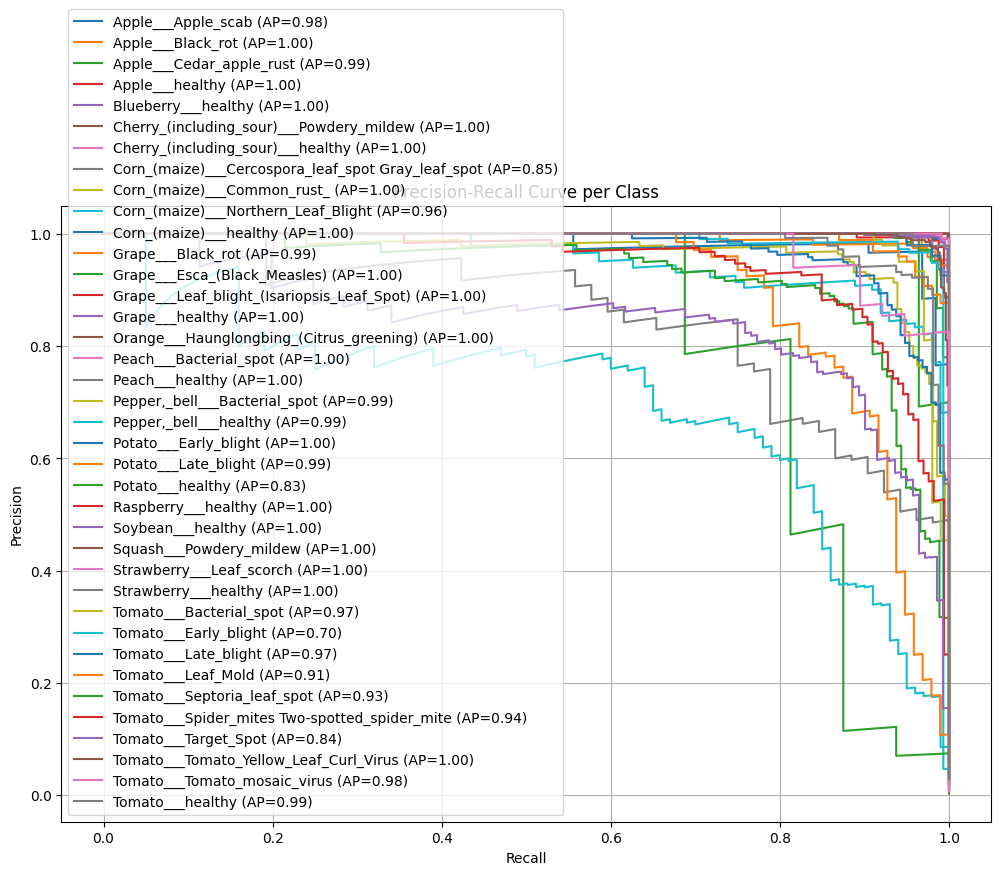

In [11]:
# 🔢 שלב 8 – גרף תוצאות (דיוק והפסד לאורך האפוקים)
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

# 🔢 שלב 8.1 – מטריצת בלבול ודו"ח סיווג
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ניבוי על סט הטסט
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# מטריצת בלבול
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# מיפוי הקלאסים
class_labels = {v: k for k, v in train_gen.class_indices.items()}
class_names = list(class_labels.values())

# דוח סיווג
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\n📋 Classification Report:\n")
print(report)

# 🔢 שלב 8.2 – Precision-Recall Curve per Class
from sklearn.metrics import precision_recall_curve, average_precision_score

n_classes = len(class_labels)
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_score = y_pred

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{class_labels[i]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



In [12]:
# 🔢 שלב 9 – שמירת המודל
# ⚠️ שים לב: שלב זה יעבוד רק אם האימון (model) עדיין בזיכרון. אם לא – טען מהcheckpoint בשלב 6:
# model = tf.keras.models.load_model("/content/best_model.keras")

model.save("/content/plant_model.keras")  # פורמט חדש מומלץ
model.save("/content/plant_model.h5")     # פורמט HDF5 – תואם לגרסאות ישנות     # פורמט HDF5 – תואם לגרסאות ישנות

# 🔢 שלב 9.1 – טעינת המודל מה־checkpoint במידת הצורך
# אם model אינו בזיכרון (למשל אחרי הפעלה מחדש), ניתן לטעון אותו כך:
# import tensorflow as tf
# model = tf.keras.models.load_model("/content/best_model.keras")


In [13]:
# 🔢 שלב 10 – שמירת מיפוי הקטגוריות
import json
with open("/content/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=4)

# 🔢 שלב 11 – סיכום
print("\n\u2705 תהליך האימון, השמירה וההערכה הושלם בהצלחה!")


✅ תהליך האימון, השמירה וההערכה הושלם בהצלחה!
